# 7. Merged dataset (VIENNA + external collaborator cohorts) - exploratory analysis (rerun)

- **Load cohorts from separate XLSX files and merge into a single table**
    - perform preprocessing:
        - keep only strictly compensated patients
        - HVPG and LAB measurements no more than 6 months apart
- **Show**:
    - number of patients in each cohort + parameter availability
    - distribution of HVPG labels (below/above 16) in each cohort
    - etiology distribution in each cohort
    - parameter distributions in different cohorts, compare patients with HVPG < 16 and HVPG >= 16 within each cohort
    - the same above but compare different etiologies
- Corresponds to Figure 1 in manuscript

<sub>original notebook name: `VICIS_14_collaborator_data_explore_rerun.ipynb`</sub>

In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# tests for boxplots
from statannot import add_stat_annotation
# plotting configuration - set size, use high resolution
from IPython.display import set_matplotlib_formats
from matplotlib import rc_params
set_matplotlib_formats('retina')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Helvetica'

/var/folders/rb/y91w78gd2_sdrdl2sglwd_q91gs47h/T/ipykernel_1762/4136239426.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


### Load VICIS and external collaborator datasets

- input: manually preprocessed excel files
- column names without spaces
- unified representation of missing values (blank, not "na" or 9999)
- rescaled values to correct units (CHE, Schepis)
- excluded patients based on comments from Benedikt
- patients NOT excluded (at this stage) based on HVPG/lab date or strict compensation or missing measurements

In [2]:
input_folder = "/Users/jreinis/OneDrive/Rotation/rotation/data_collaborators_updated_v3/preprocessed/"
files = ["ALBILLOS_preprocessed.xlsx",
         "GARCIA-PAGAN_preprocessed.xlsx",
         "KWANTEN_preprocessed_2021-08-11.xlsx",
         "RAUTOU_preprocessed_2021-08-11.xlsx",
         "SCHEPIS_preprocessed_2021-08-11.xlsx",
         "TREBICKA_preprocessed_2021-08-11.xlsx",
         "VIENNA_preprocessed_2021-08-11.xlsx",
         "VILLANUEVA_preprocessed_2021-08-11.xlsx"]

# used to rename datasets not according to the collaborator but rather the institution
collab_centers = {"VIENNA": "VIENNA",
                  "KWANTEN": "ANTWERP",
                  "VILLANUEVA": "BARCELONA-HSP",
                  "GARCIA-PAGAN": "BARCELONA-HC",
                  "TREBICKA": "FRANKFURT",
                  "ALBILLOS": "MADRID",
                  "SCHEPIS": "MODENA",
                  "RAUTOU": "PARIS"}

output_folder = "/Users/jreinis/OneDrive/Rotation/rotation/data_collaborators_updated_v3/"
plot_folder = "/Users/jreinis/OneDrive/Rotation/rotation/HVPG16_manuscript_figures/"

filepaths = [input_folder+file for file in files]

In [3]:
# parameters we want to extract for each dataset
parameters = ["dataset", "Center-ID", "Age", "Sex", "Etiology", "STRICTLY_COMPENSATED", "Date_HVPG", "Date_LAB", 
              "HVPG", "VCTE-LSM-kPa", "PLT", "BILI", "GGT", "aPTT", "CHE", "INR", "MELD-Score", "CHILD-Score"]

# parameter names to be changed
par_name_change = {"MELD-Score": "MELD",
                   "CHILD-Score": "Child-score",
                  }

In [4]:
def extract_main_info(input_folder, file, parameters):
    #print(file)
    x = pd.read_excel(input_folder+file)
    x["dataset"] = re.sub("_preprocessed.*.xlsx", "", file)
    #x["Date_HVPG"] = [pd.to_datetime(_) for _ in x["Date_HVPG"]]
    return x[parameters]

In [5]:
datasets = [extract_main_info(input_folder, file, parameters) for file in files]

In [6]:
data_raw = pd.concat(datasets).reset_index(drop=True)
print(data_raw.shape)

(1184, 18)


In [7]:
# rename datasets to collaboartor institute:
data_raw["dataset"] = data_raw["dataset"].map(collab_centers)
# rename certain columns
data_raw.rename(columns=par_name_change, inplace=True)

### Keep only strictly compensated patients, with an HVPG measurement less than 6 months apart from the measurement of lab parameters

In [9]:
# calculate how many days between HVPG and LAB measurements
data_raw['Date_HVPG'] = pd.to_datetime(data_raw['Date_HVPG'])
data_raw['Date_LAB'] = pd.to_datetime(data_raw['Date_LAB'])
data_raw["LAB_HVPG_delta"]= abs(data_raw['Date_HVPG'] - data_raw['Date_LAB'])

In [10]:
# filter out patients with missing HVPG measurement or not strictly compensated
data = data_raw.query('HVPG.notnull() & STRICTLY_COMPENSATED == "YES"').copy()

# filter out patients with HVPG and LAB measurements more than 180 days apart
data = data[data.LAB_HVPG_delta < pd.Timedelta(180, unit="d")].copy()

# convert time delta to days (absolute value)
data["LAB_HVPG_delta"] = data["LAB_HVPG_delta"].astype("timedelta64[D]").astype("int64")

In [12]:
# save as csv/xlsx
data.to_csv(output_folder+"merged_datasets_HVPG_strictly_compensated_center_names.csv", index=None)
data.to_excel(output_folder+"merged_datasets_HVPG_strictly_compensated_center_names.xlsx")

In [13]:
# reload
data = pd.read_csv(output_folder+"merged_datasets_HVPG_strictly_compensated_center_names.csv")

### See how many measurements we have for each parameter in each dataset after filtering

In [14]:
parameters_show = ["Age", "Sex", "Etiology", "HVPG", "VCTE-LSM-kPa", "PLT", "BILI", "GGT", "aPTT", "CHE", "INR", "MELD", "Child-score"]
dataset_order = collab_centers.values()

In [15]:
data['dataset'] = pd.Categorical(data['dataset'], categories=dataset_order, ordered=True)
counts = data.groupby("dataset")[parameters_show].count()
percentages = counts[parameters_show].div(counts.HVPG, axis=0)

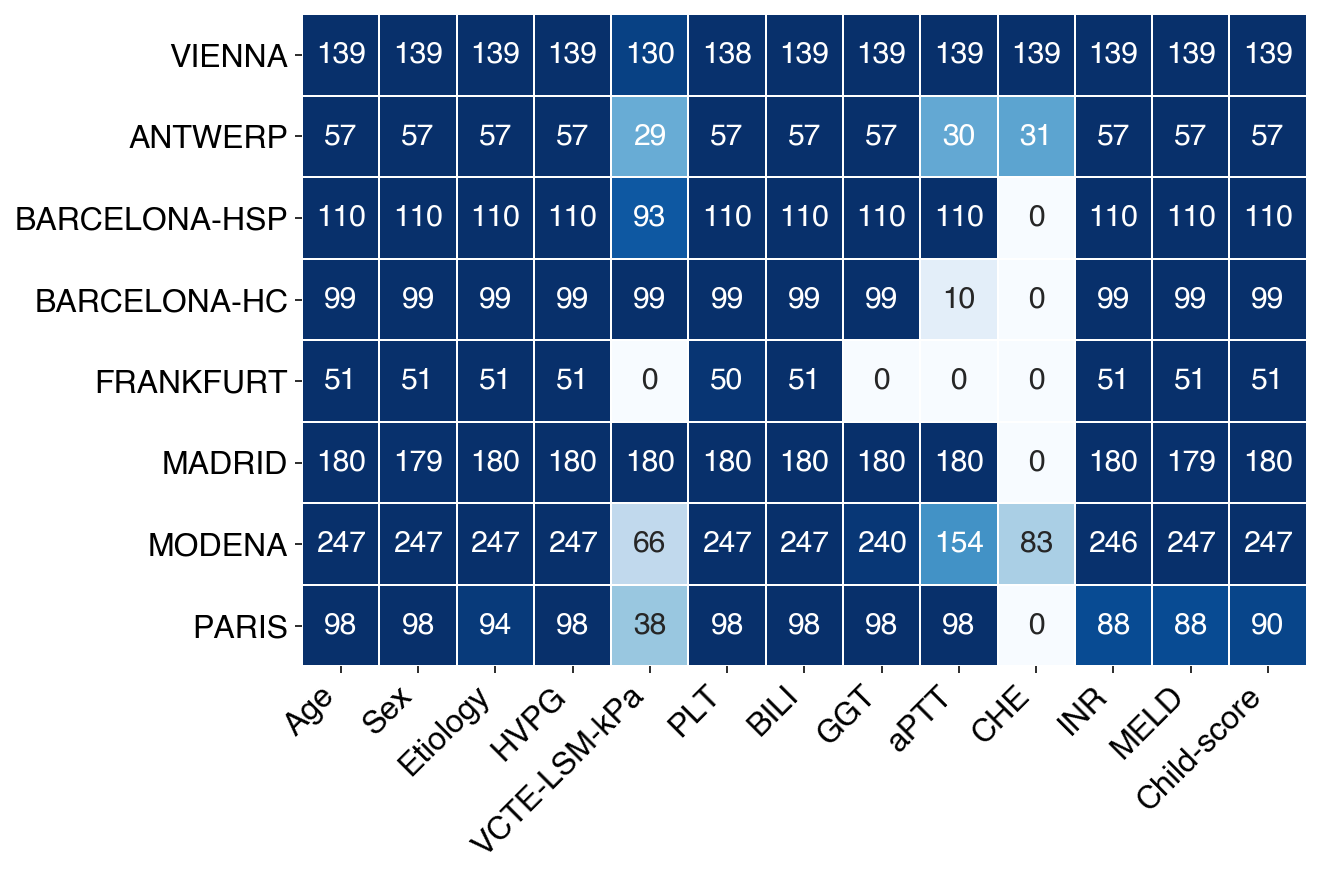

In [16]:
plt.figure(figsize=(9,6))
g = sns.heatmap(percentages, annot=counts, fmt='g', cmap="Blues", linewidths=1, cbar=False, annot_kws={"fontsize":15})
g.set(ylabel=None)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
g.set_xticklabels(parameters_show, rotation = 45, ha="right")

plt.savefig(plot_folder+"datasets_overview.pdf", bbox_inches="tight")
plt.show()

### See how many high-risk patients (HVPG >= 16) we have for each dataset

In [17]:
data["HVPG_label"] = "HVPG < 16"
data.loc[data.HVPG >= 16, 'HVPG_label'] = "HVPG ≥ 16"

In [18]:
# update center names for the x axis - put Barcelona center names on a newline in parentheses
dataset_order_labels = []
for center_name in dataset_order:
    center_name = center_name.replace("-", "\n(")
    if "\n" in center_name:
        center_name = center_name + ")"
    dataset_order_labels.append(center_name)

In [19]:
def tweak_boxplot_v2(a, dataset_order_labels):
    a.set_yticklabels(dataset_order_labels)
    handles, labels = a.get_legend_handles_labels()     # remove "HVPG_label" text (variable name) from the legend
    a.legend(handles=handles[:], labels=labels[:])
    a.set_ylabel(None)                                  # x/y axis labels

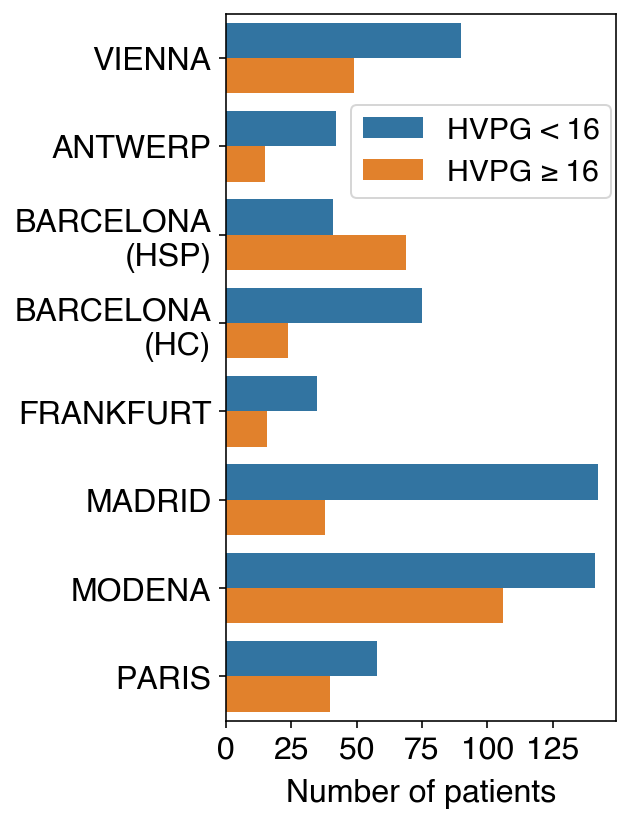

In [20]:
# the same but swap axis
plt.figure(figsize=(3.5,6.5))
ax = sns.countplot(y = 'dataset', data = data, hue = "HVPG_label", )

# update x axis tick labels to make long center names fit
ax.set_yticklabels(dataset_order_labels)

# remove "HVPG_label" text (variable name) from the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:])

# x/y axis labels
ax.set_ylabel(None)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Number of patients", fontweight="bold", labelpad=7, fontsize=16)
plt.legend(fontsize=15, loc=(0.32 ,0.74))

plt.savefig(plot_folder+"total_numbers_strictly_compensated.pdf", bbox_inches="tight")
plt.show()

### Compare parameters between datasets, consider etiology

`Etiology (ALD=1; VIRAL=2; ALD+VIRAL=3;NASH=4;CHOL=5;OTHER=6)`

In [21]:
def tweak_boxplot(a, dataset_order_labels):
    a.set_xticklabels(dataset_order_labels)
    handles, labels = a.get_legend_handles_labels()     # remove "HVPG_label" text (variable name) from the legend
    a.legend(handles=handles[:], labels=labels[:])
    a.set_xlabel(None)                                  # x/y axis labels

In [22]:
etiology_codes = {1:"ALD",
                  2:"VIRAL",
                  3:"ALD+VIRAL",
                  4:"NASH",
                  5:"CHOL",
                  6:"OTHER"}

In [23]:
# only accept the etiologies with the codes above
data["Etiology"] = pd.to_numeric(data["Etiology"], errors='coerce')
# keep only record that have only one etiology reported
data_simple_etiology = data[data["Etiology"].isin(list(range(1,7)))].copy()
# change the number convention to names
data_simple_etiology.replace({"Etiology":etiology_codes}, inplace=True)

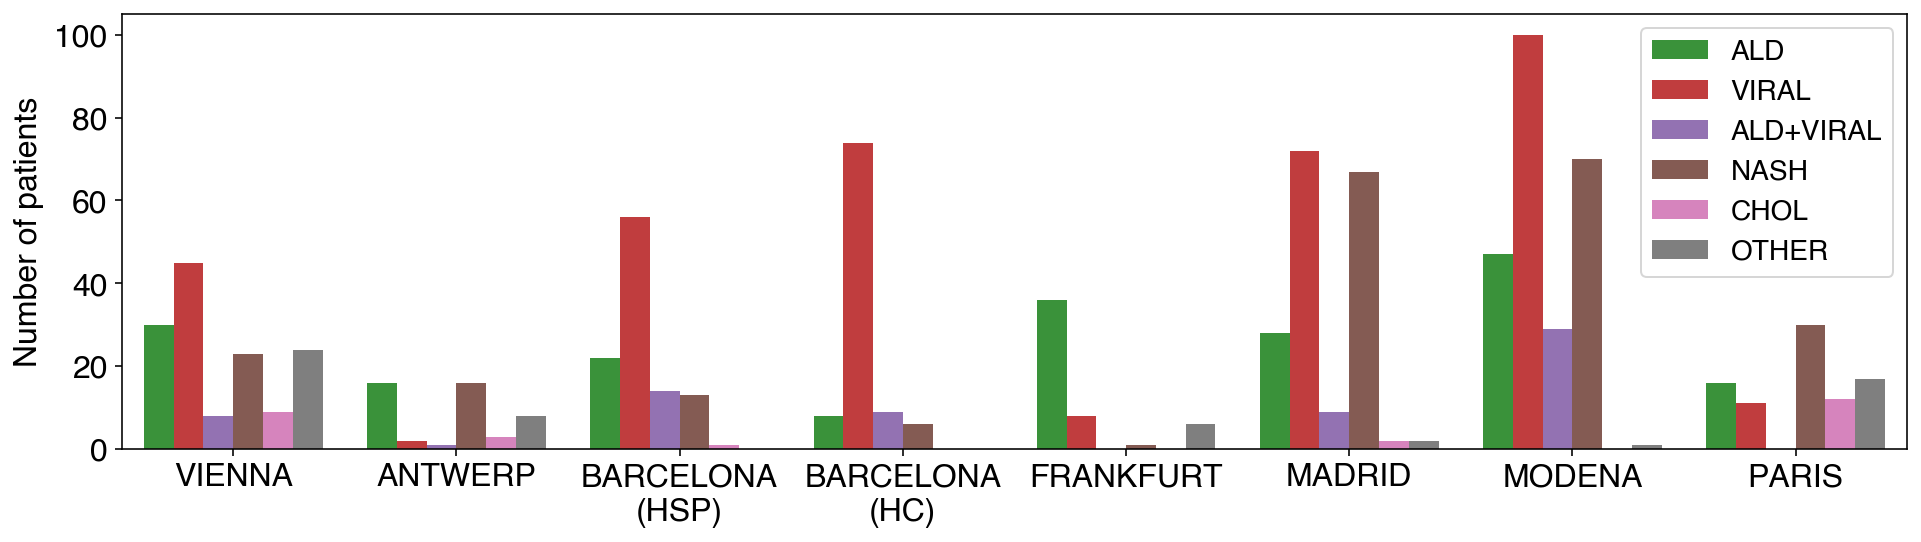

In [24]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x = 'dataset', data = data_simple_etiology, hue = "Etiology", palette=sns.color_palette()[2:])
tweak_boxplot(ax, dataset_order_labels)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel("Number of patients", fontweight="bold", labelpad=5, fontsize=16)
plt.legend(fontsize=14, loc=1)
plt.savefig(plot_folder+"total_numbers_strictly_compensated_etiology.pdf", bbox_inches="tight")
plt.show()

### Look at distributions of parameters, consider high/low risk, plot against HVPG

In [25]:
data = data.astype({'aPTT': 'float64',
                    "VCTE-LSM-kPa": 'float64',
                    'CHE': 'float64',
                    'INR': 'float64',
                    'Child-score': 'float64'})

In [26]:
# define comparisons for statistical testing
box_pairs = [((dataset_name, "HVPG < 16"),(dataset_name, "HVPG ≥ 16")) for dataset_name in dataset_order]

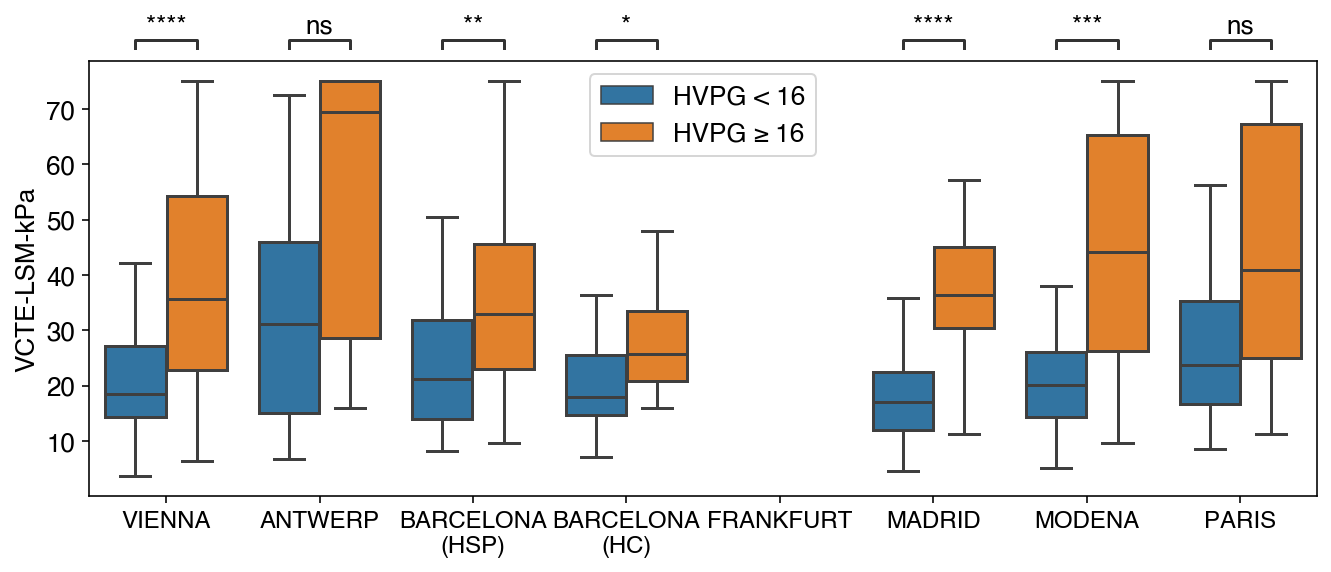

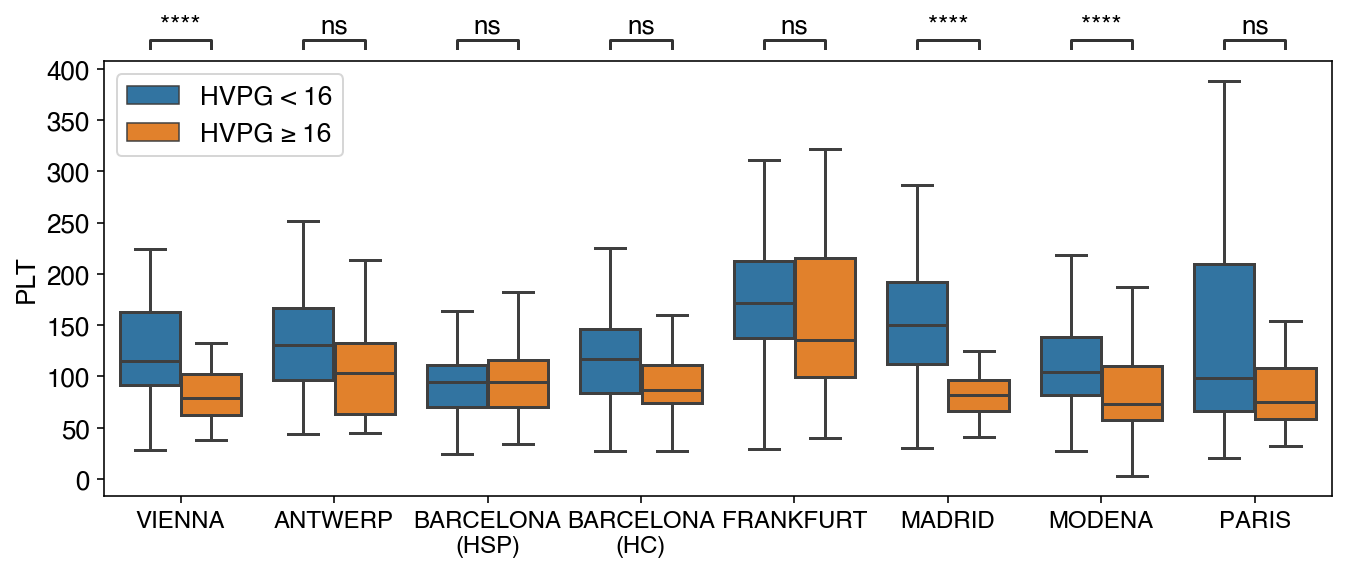

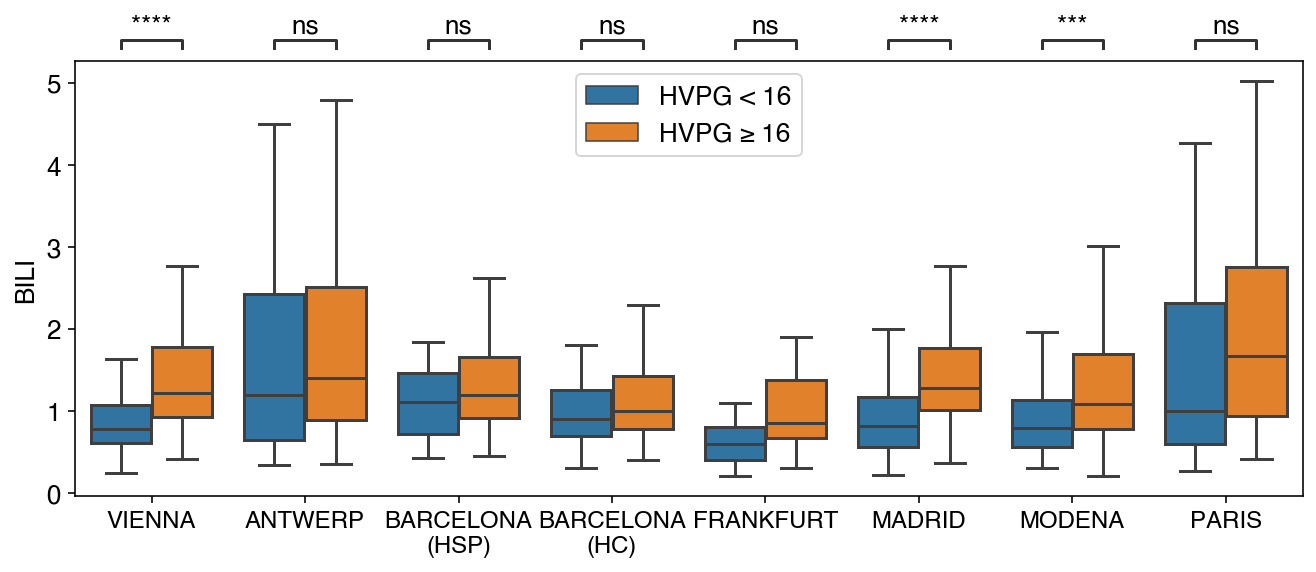

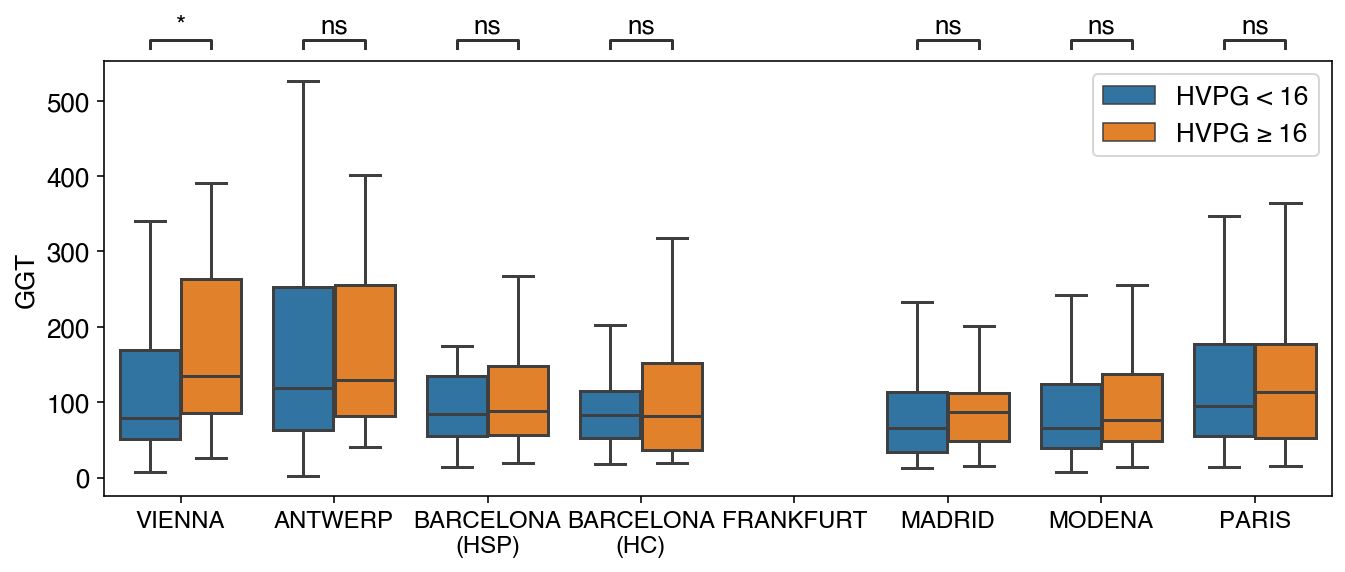

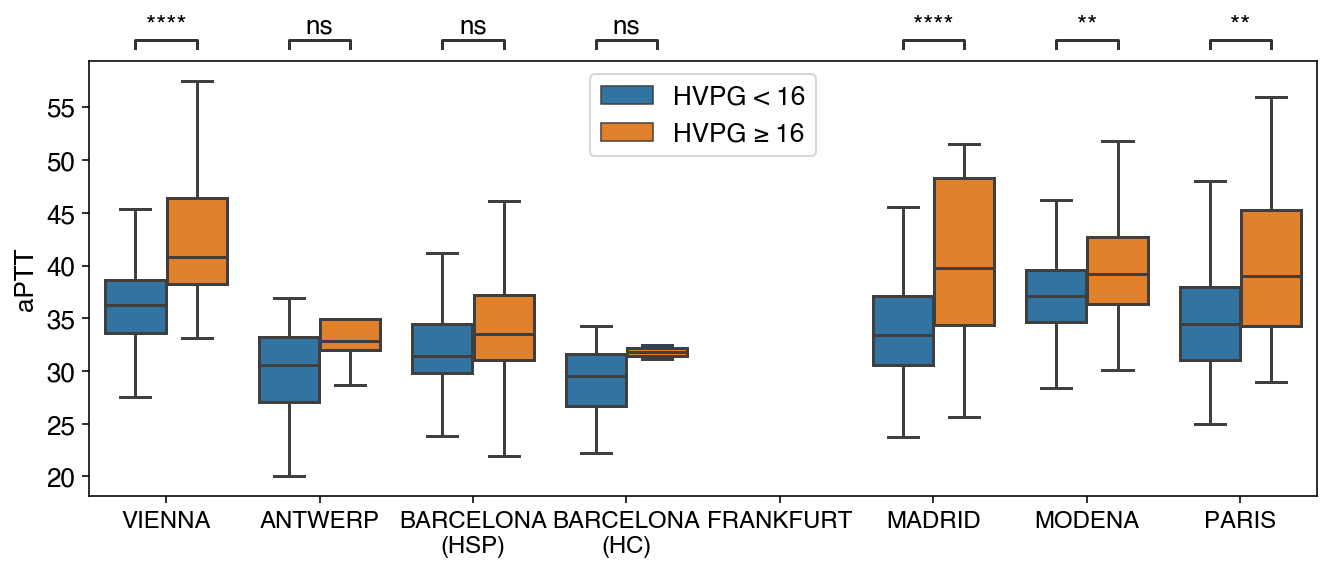

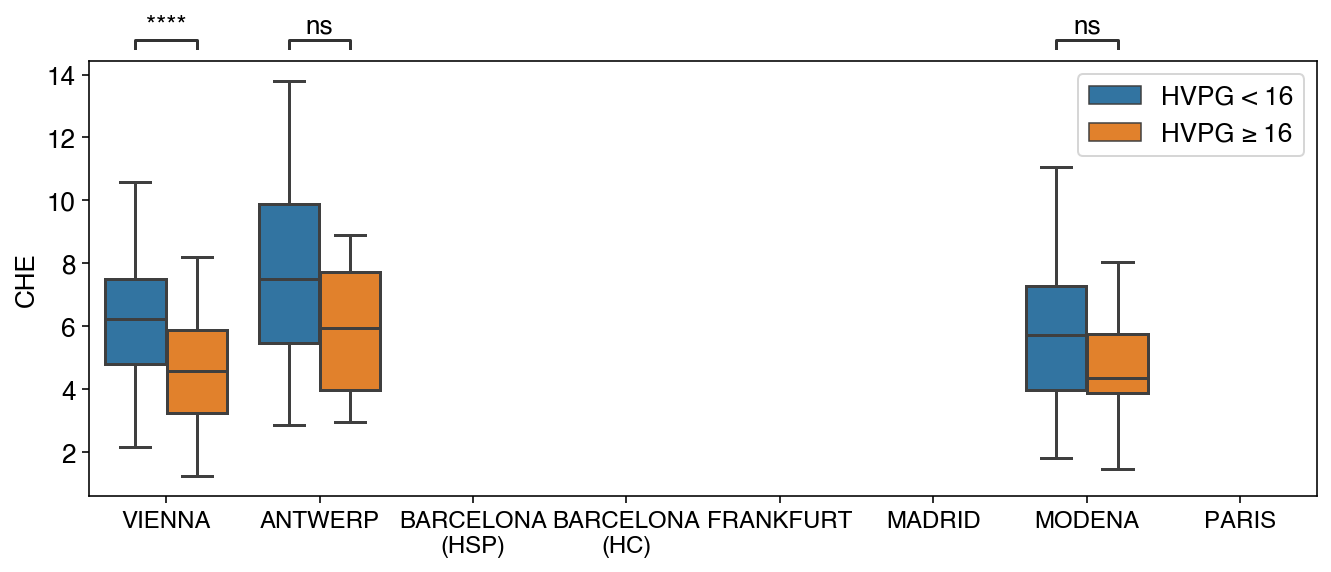

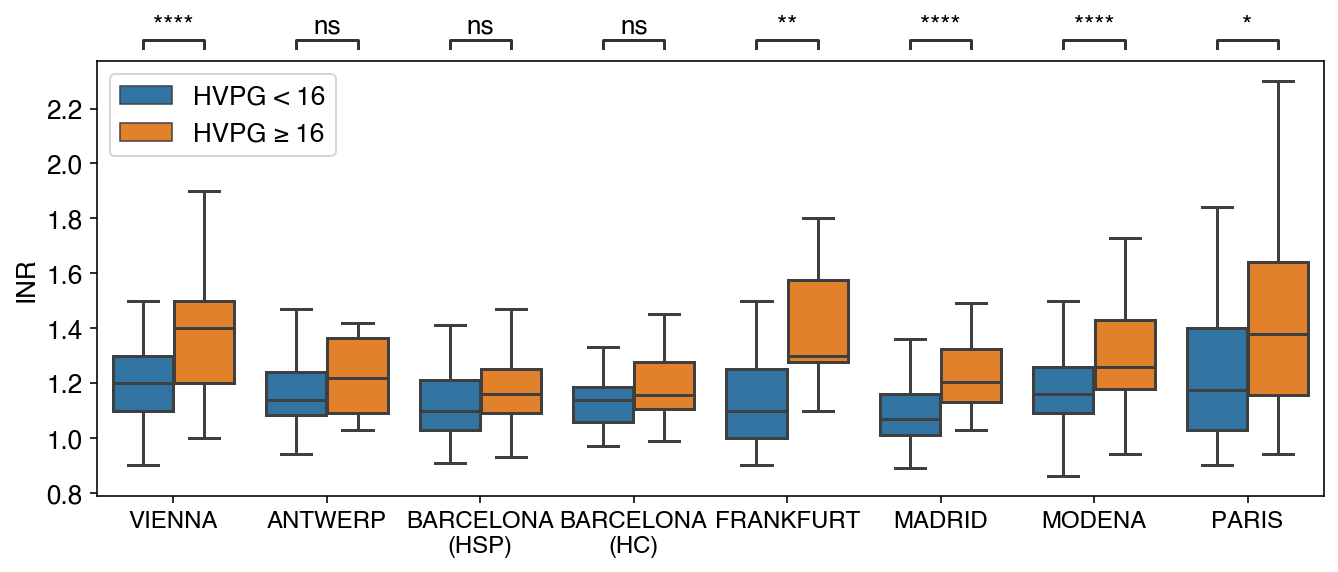

In [27]:
numeric_parameters = ["VCTE-LSM-kPa", "PLT", "BILI", "GGT", "aPTT", "CHE", "INR"]

for parameter in numeric_parameters:
    plt.figure(figsize=(11,4))
    ax = sns.boxplot(data=data, x="dataset", y=parameter, hue="HVPG_label", showfliers = False) # showfliers = False not to show outliers making the the axis scale unusable
    add_stat_annotation(ax, data=data, x="dataset", y=parameter, hue="HVPG_label",
                        box_pairs=[box_pairs[i] for i,count in enumerate(counts[parameter]) if count], # test only in case there is data
                        test='Mann-Whitney', text_format='star', loc='outside', verbose=0, fontsize=13)
    
    tweak_boxplot(ax, dataset_order_labels)    
    plt.savefig(f"{plot_folder}/parameters_distributions/{parameter}.pdf", bbox_inches="tight")
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=12)
    plt.ylabel(parameter, fontsize=13)
    plt.legend(fontsize=13)
    plt.show()    

### Addendum: parameter distributions for different etiologies in different datasets

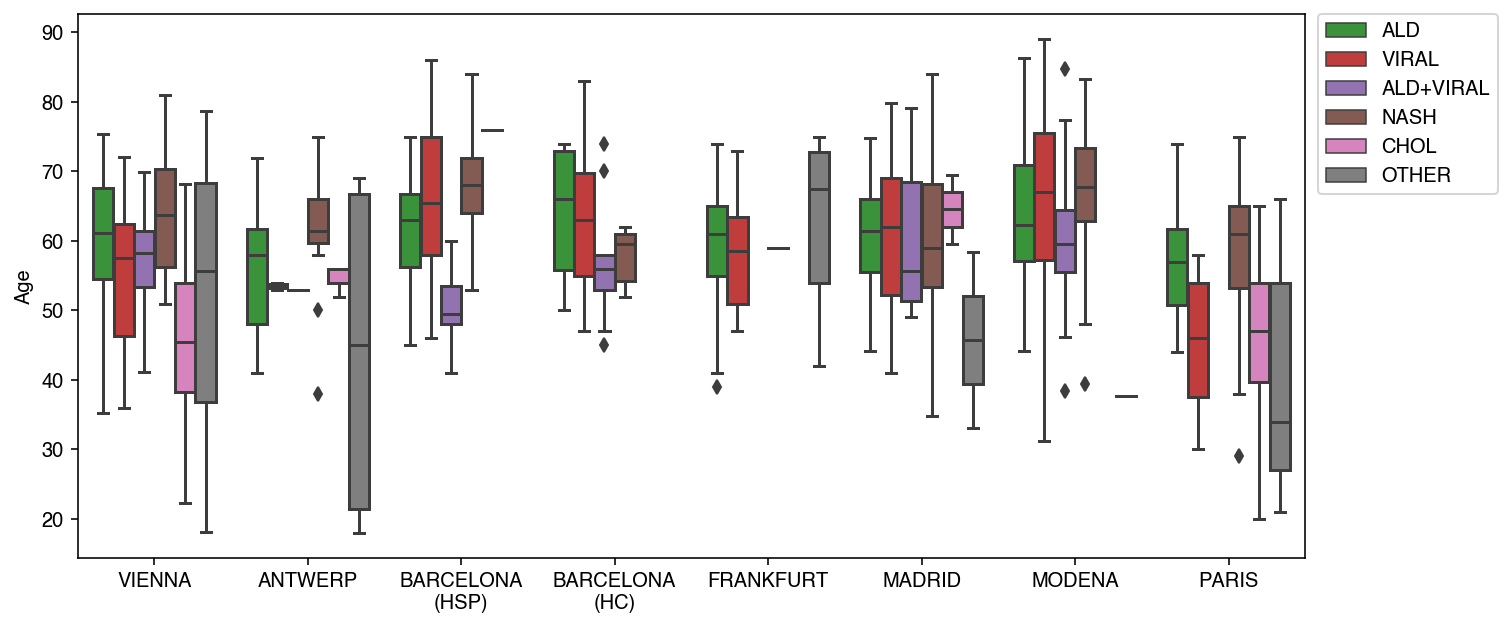

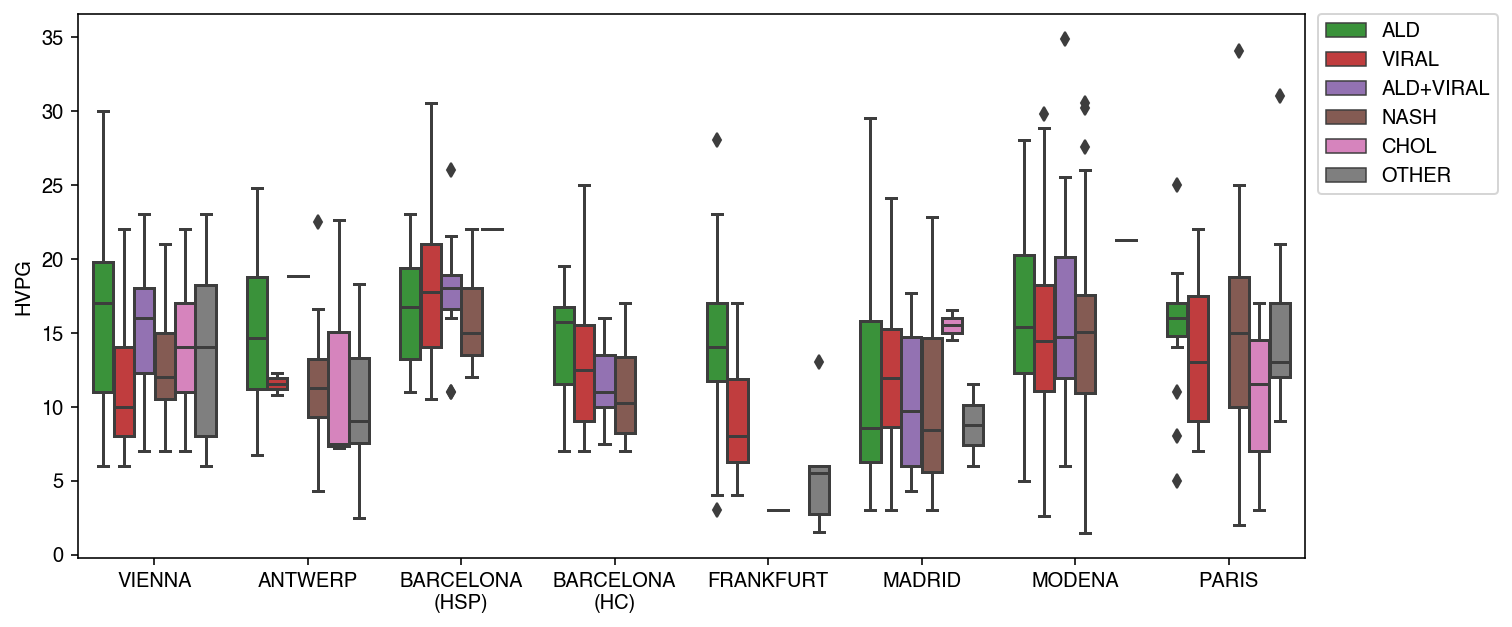

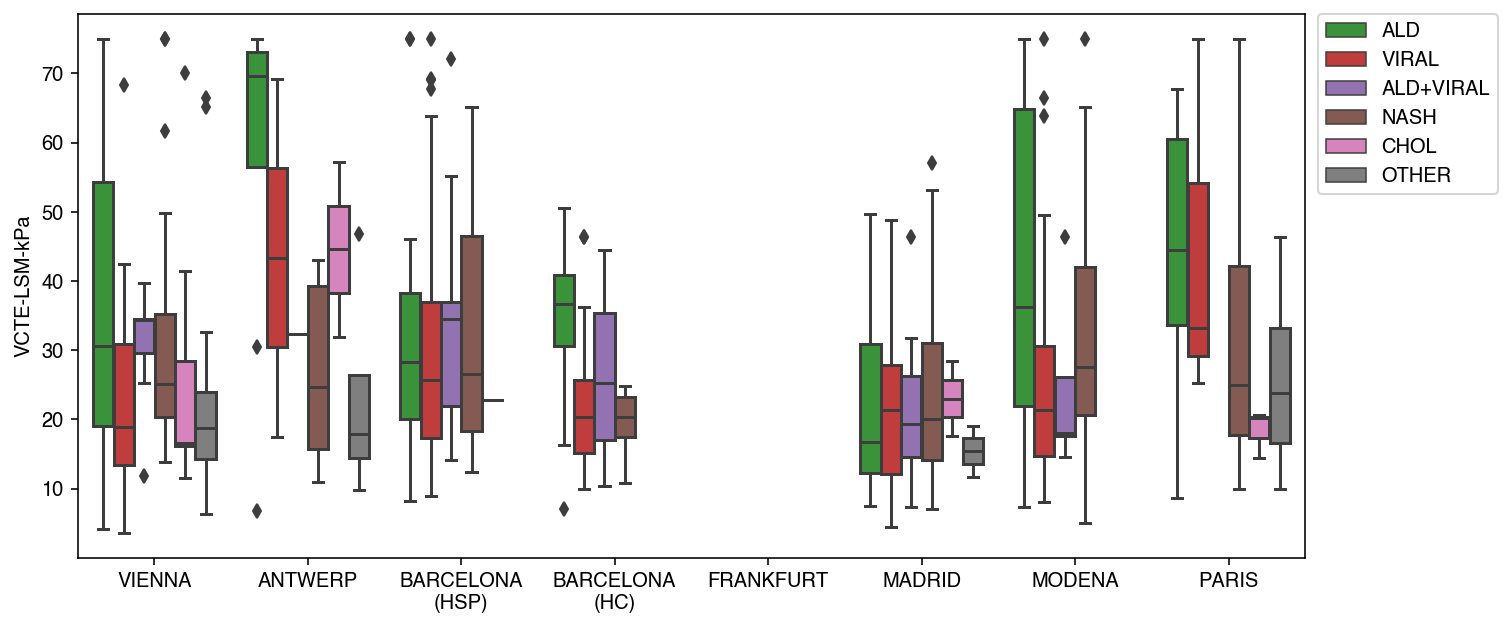

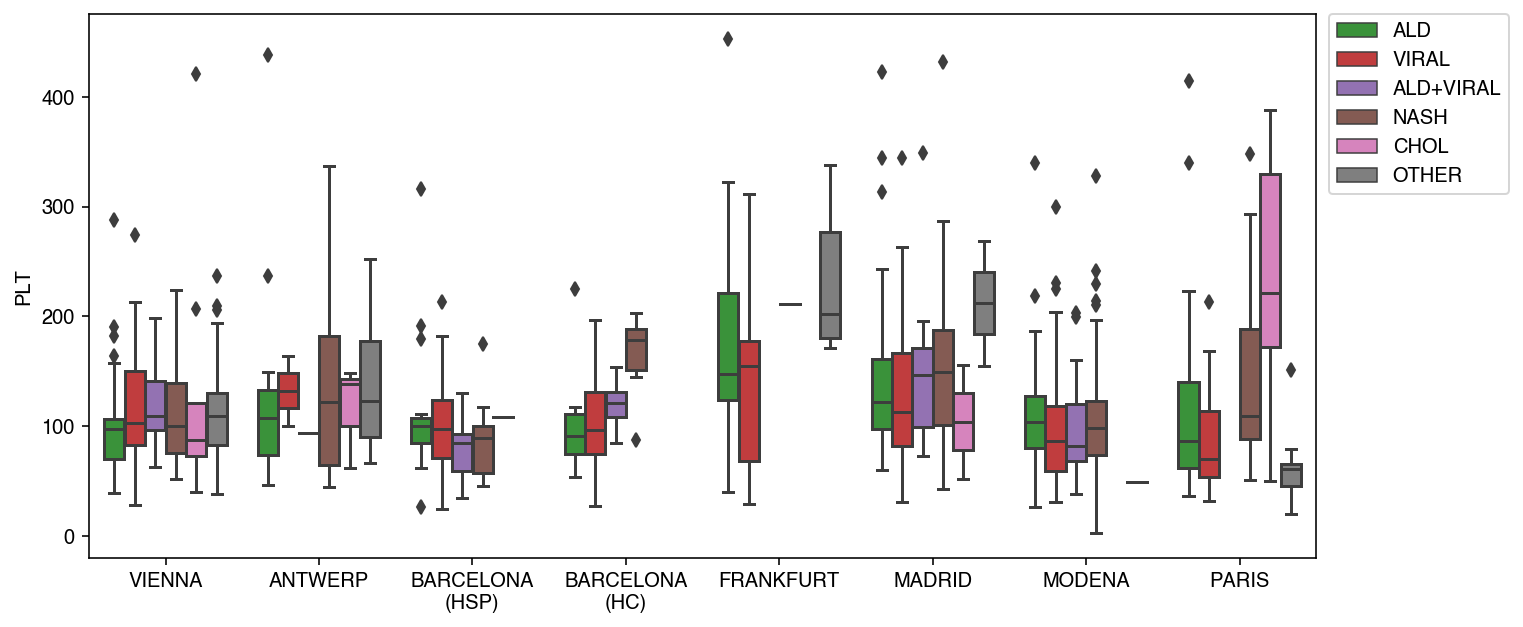

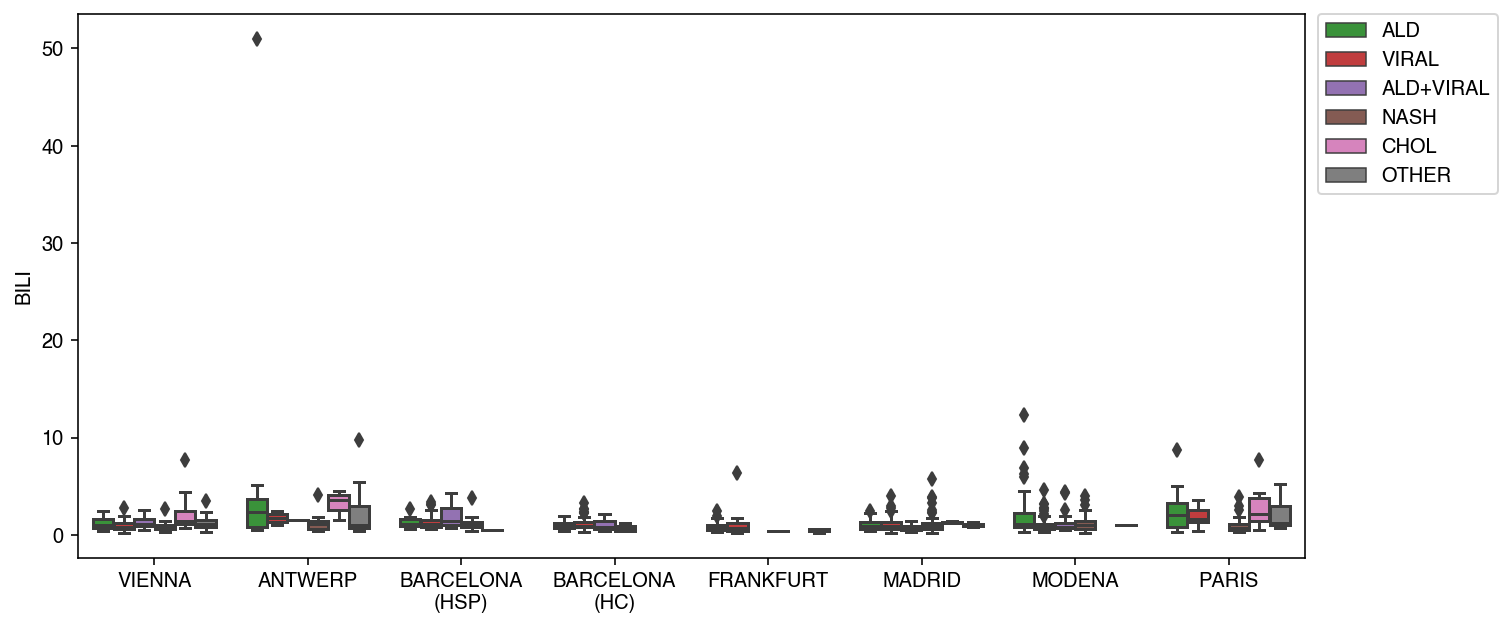

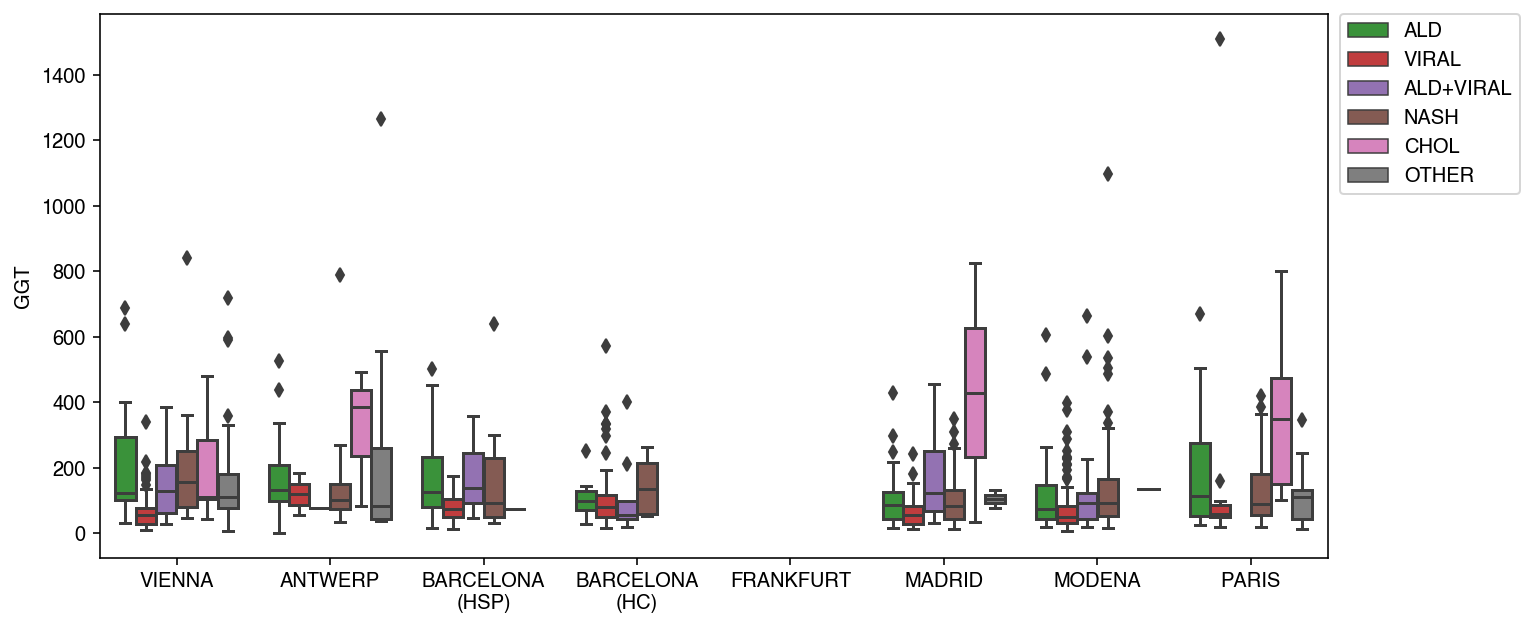

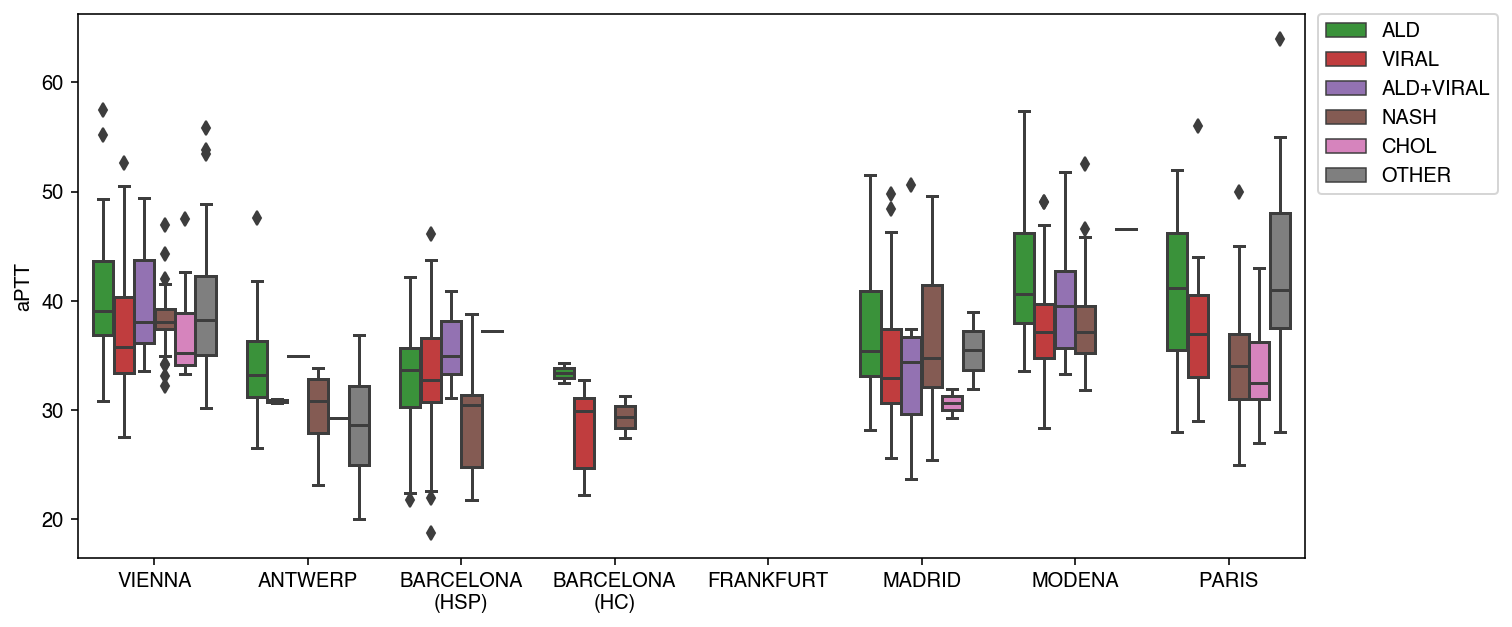

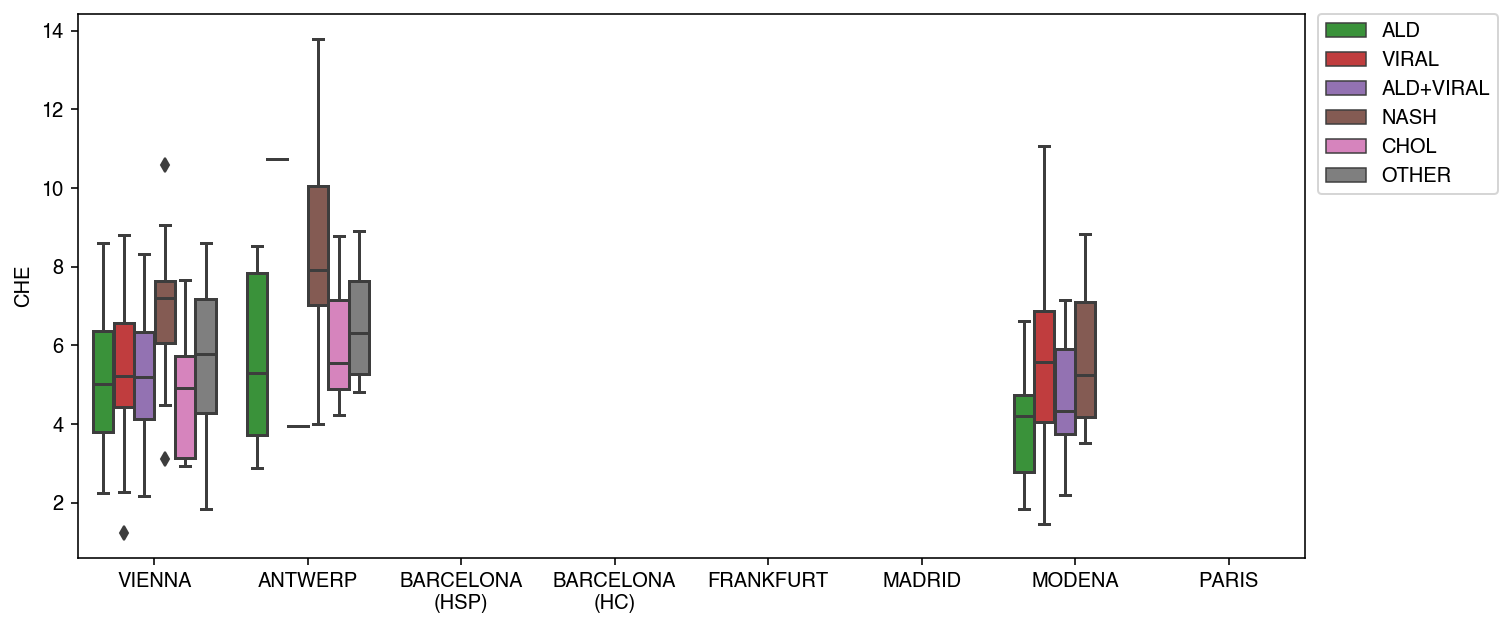

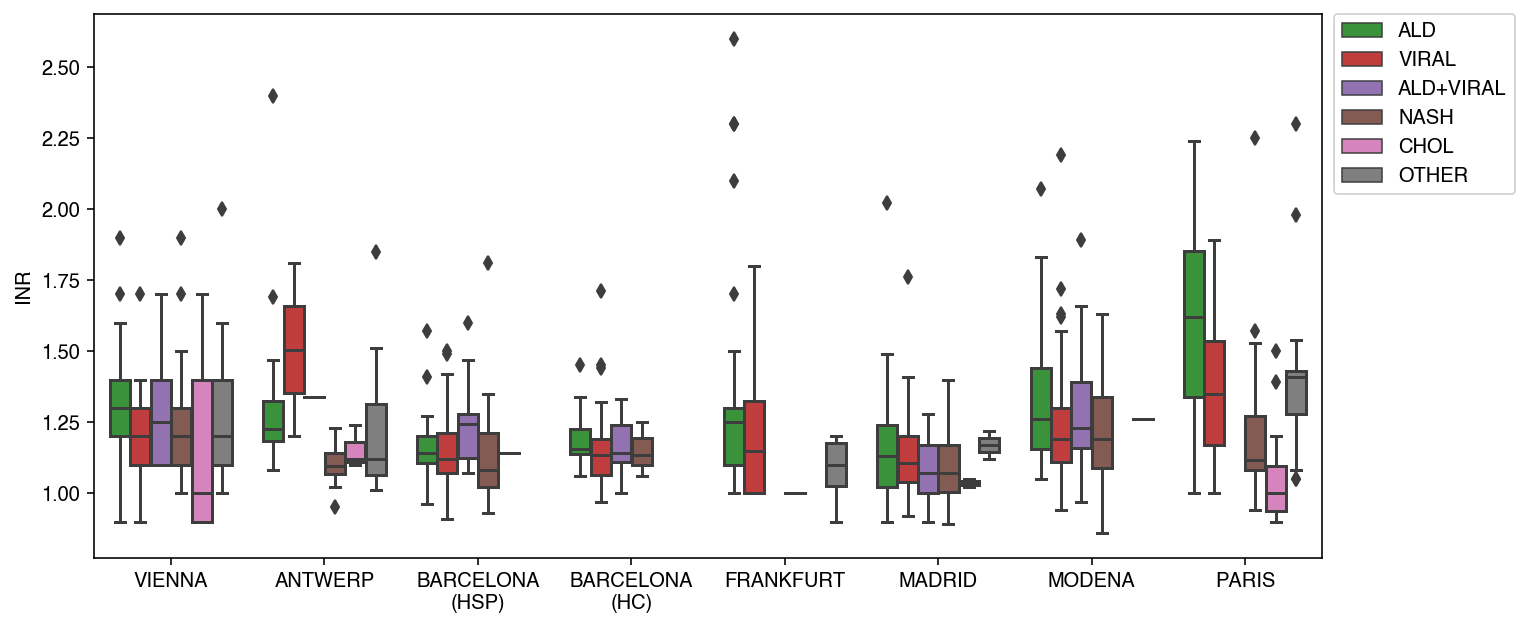

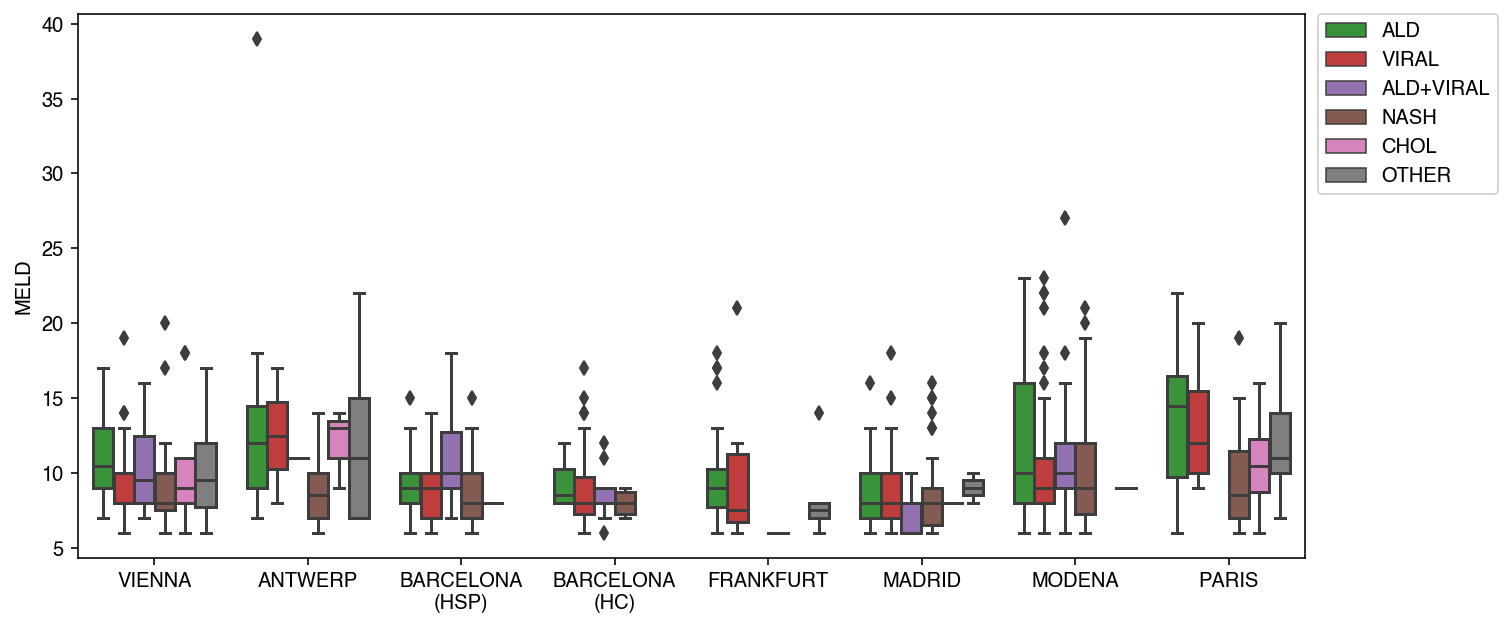

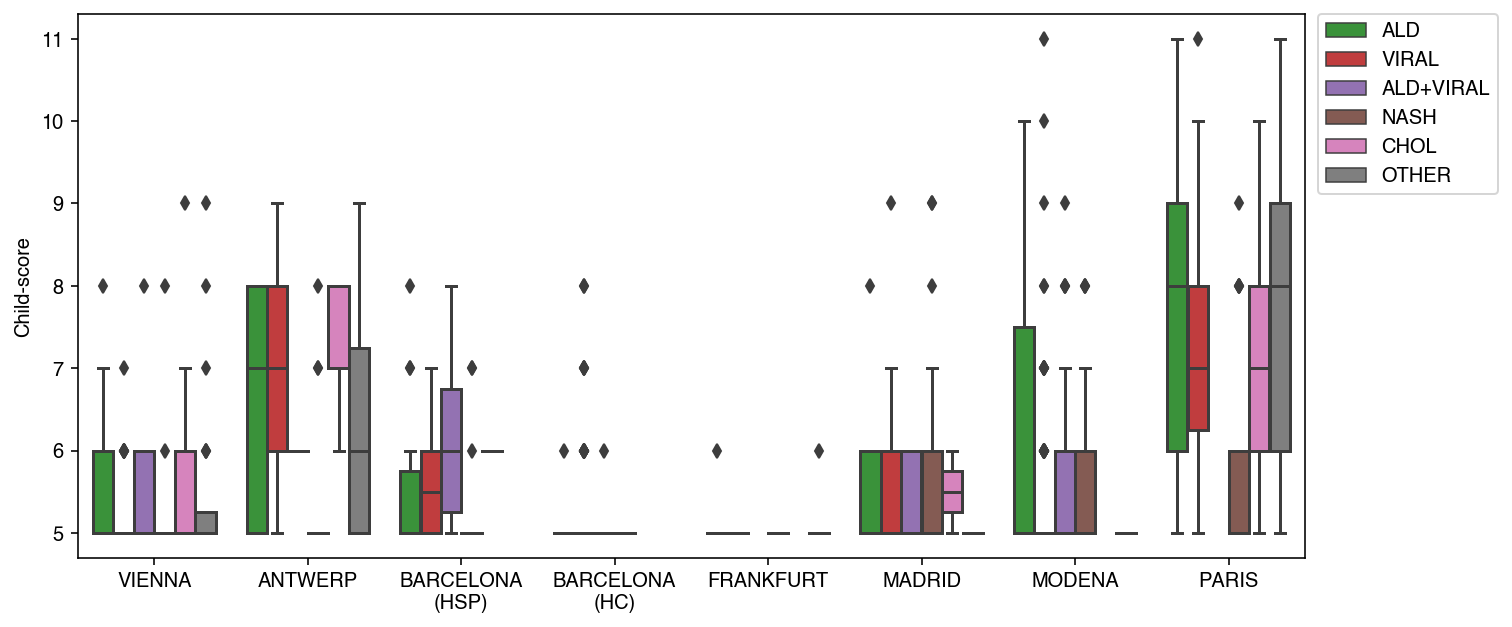

In [28]:
numeric_parameters = ["Age", "HVPG", "VCTE-LSM-kPa", "PLT", "BILI", "GGT", "aPTT", "CHE", "INR", "MELD", "Child-score"]

for parameter in numeric_parameters:
    plt.figure(figsize=(11,5))
    ax = sns.boxplot(data=data_simple_etiology, x="dataset", y=parameter, hue="Etiology", palette=sns.color_palette()[2:])
    tweak_boxplot(ax, dataset_order_labels)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.savefig(f"{plot_folder}/parameters_distributions_etiology/{parameter}_etiology.pdf", bbox_inches="tight")
    plt.show()